len of df_T 175
len of df_T_forecast 100


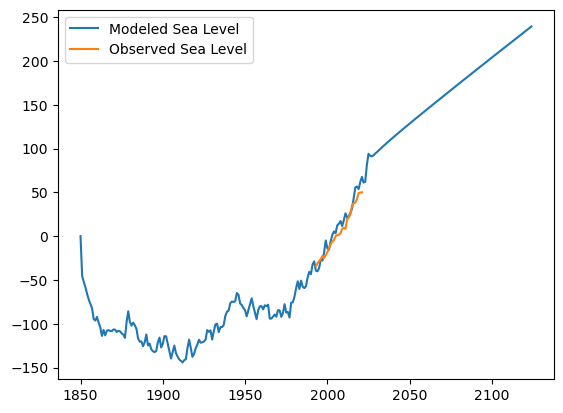

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner

def box_model(T, S_0, a, b, tau):
    S = np.zeros(len(T))
    S[0] = S_0
    S_eq = a * T + b
    dS = np.zeros(len(T))
    for t in range(1, len(T)):
        dS_dt = (S_eq[t-1] - S[t-1]) / tau
        S[t] = S[t-1] + dS_dt
        dS[t] = dS_dt
    return dS

def four_box_model(T, S_0, a, b, tau0, tau1, tau2, tau3):
    greenland = box_model(T, S_0, a, b, tau0)
    antarctica = box_model(T, S_0, a, b, tau1)
    glaciers = box_model(T, S_0, a, b, tau2 )
    thermal_expansion = box_model(T, S_0, a, b, tau3)
    return greenland + antarctica + glaciers + thermal_expansion

def load_data(base_path = '../data/', plot=False):
    # load data
    df_T_forecast = pd.read_csv(base_path + 'T_forecast_auto_arima.csv', index_col=0)
    df_T = pd.read_csv(base_path + 'processed_temperature_data.csv', index_col=0)
    df_S = pd.read_csv(base_path + 'processed_sea_level_data.csv', index_col=0)

    # stack df_T with forecast
    print('len of df_T', len(df_T))
    print('len of df_T_forecast', len(df_T_forecast))
    df_T = pd.concat([df_T, df_T_forecast])
    df_T_annual = df_T.Annual
    df_T_uncertainty = df_T.Annual_uncertainty
    df_T_annual, df_T_uncertainty

    df_S_annual = df_S.GMSL_noGIA
    df_S_uncertainty = df_S.uncertainty

    time = df_T_annual.index
    time_S = df_S_annual.index

    if plot:
        # now the data is ready, we will plot

        fig, ax = plt.subplots(figsize=(10, 3))
        ax2 = ax.twinx()

        ax.plot(df_T_annual, label='Temperature')
        ax2.plot(df_S_annual, label='Sea Level', color='red')

        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Temperature (Celsius)')
        ax2.set_ylabel('Sea Level (mm)', color='red')

    return df_T_annual.values, df_T_uncertainty.values, df_S_annual.values, df_S_uncertainty.values, time, time_S

def align_data(df_T_annual, df_T_uncertainty):
    #df_S_annual  # 1993 : 2021
    #df_T_annual  # 1850 : 2124
    T = df_T_annual.values[143:-103]
    T_unc = df_T_uncertainty.values[143:-103]

    t = df_T_annual.index[143:-103]

    return T, T_unc, t, df_T_annual.index

T, T_unc, S_obs, sigma, time, time_S = load_data(plot=False)
dS_pred = four_box_model(T, S_0=17.825, a=50.733, b=1.639, tau0=3.574, tau1=7.641, tau2=1.258, tau3=82.404)
S_pred = np.cumsum(dS_pred)
plt.plot(time, S_pred, label='Modeled Sea Level')
plt.plot(time_S, S_obs, label='Observed Sea Level')
plt.legend()
plt.show()


Running burn-in...


100%|██████████| 1000/1000 [00:16<00:00, 60.11it/s]


Running production...


100%|██████████| 5000/5000 [01:11<00:00, 69.62it/s]


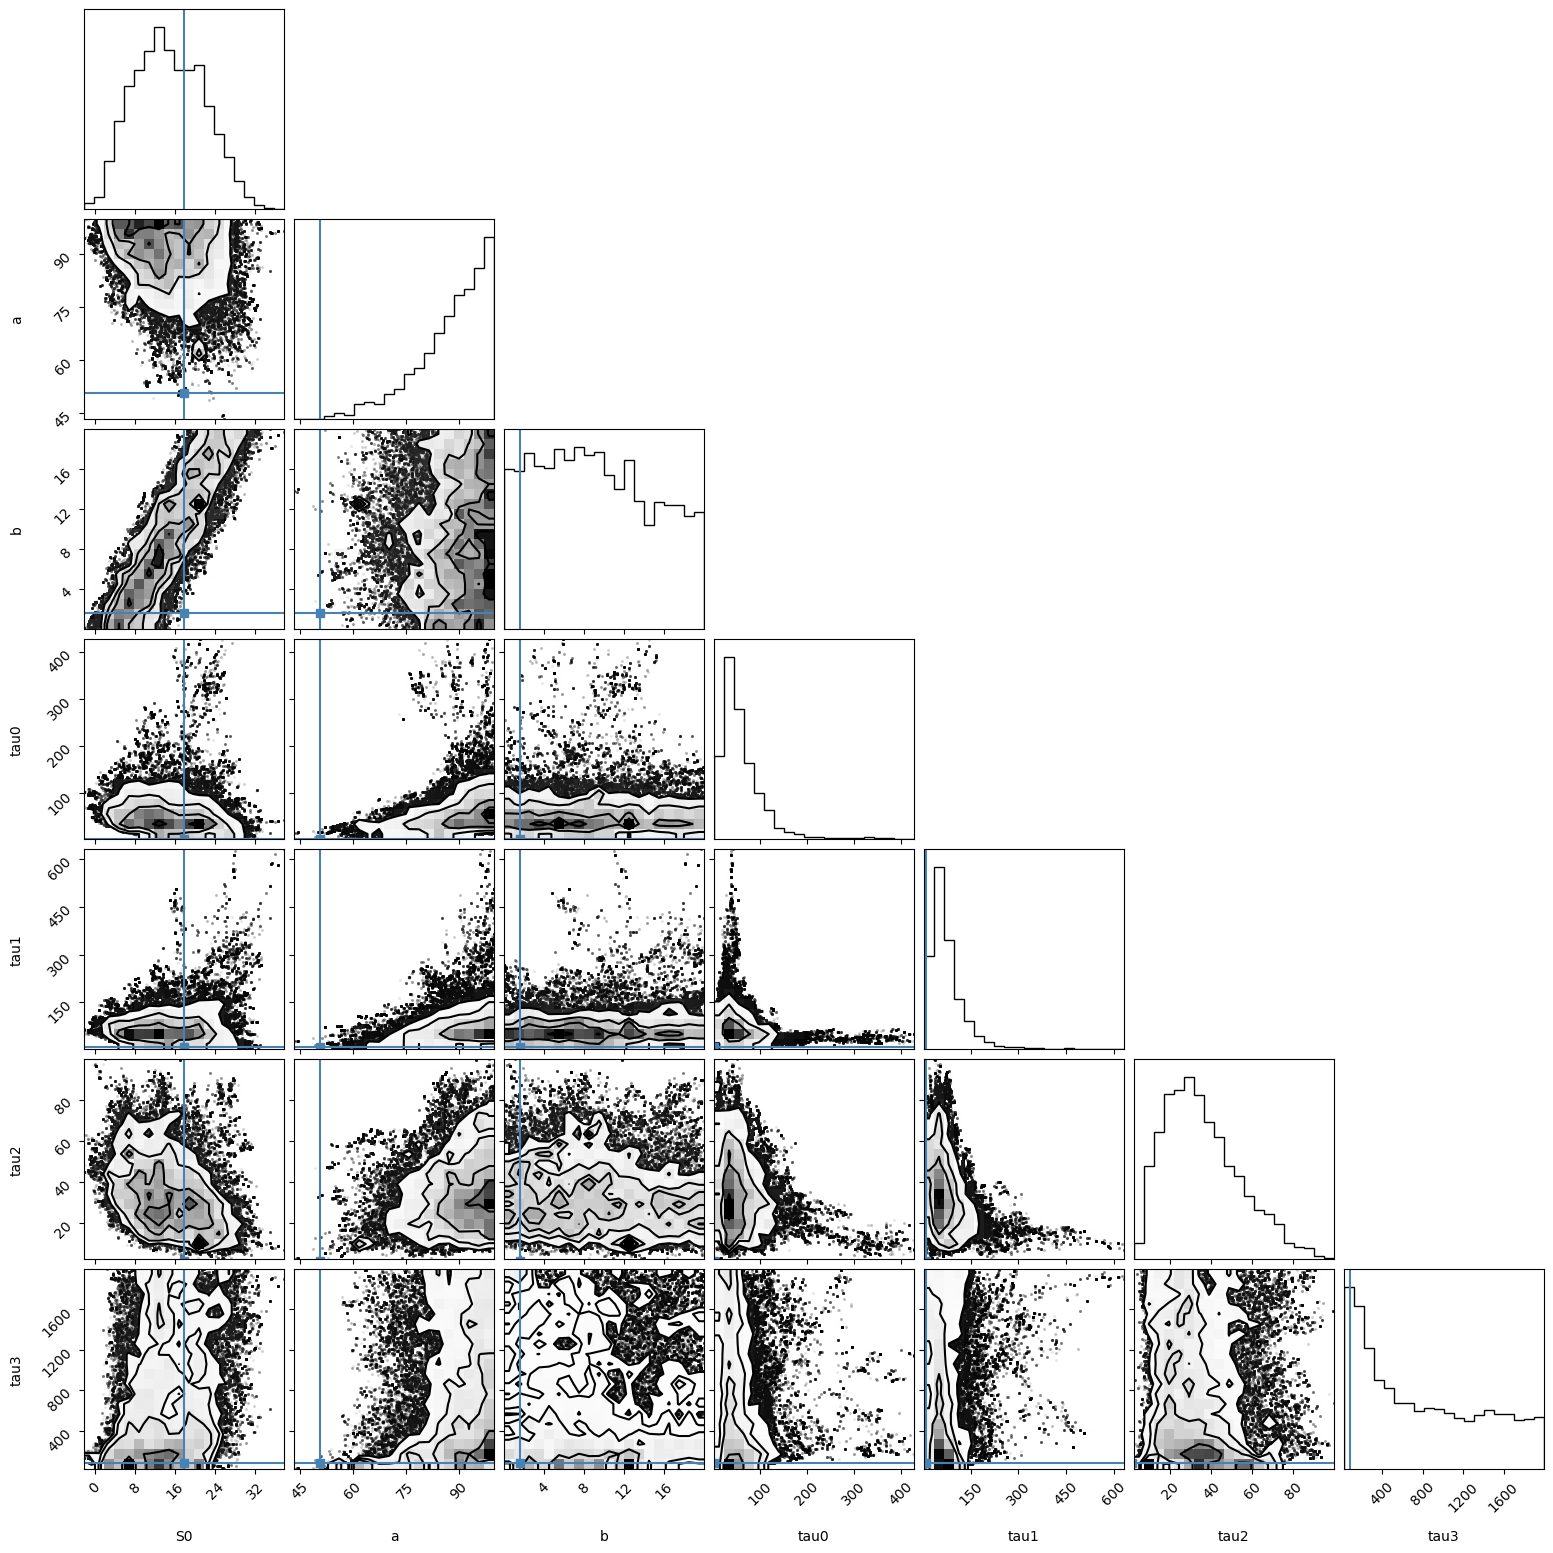

S0 = 14.372 (+7.652, -6.828)
a = 90.150 (+7.263, -12.358)
b = 8.889 (+7.099, -5.955)
tau0 = 49.200 (+46.190, -23.418)
tau1 = 60.738 (+53.151, -29.036)
tau2 = 32.736 (+22.153, -15.236)
tau3 = 665.555 (+879.758, -518.866)


In [165]:
# Assuming df_T and df_S are already provided as dataframes with relevant temperature and sea level data.

# offset = 100  # Adjust this value as needed

# Define the four-box model (assumed to be provided elsewhere)
def get_dS(T, S_0, a, b, tau0, tau1, tau2, tau3):
    return four_box_model(T, S_0, a, b, tau0, tau1, tau2, tau3)

# Define the log prior function
def log_prior_inf(theta):
    S0, a, b, tau0, tau1, tau2, tau3 = theta
    if -np.inf < S0 and S0 < np.inf and \
        -np.inf < a and a < np.inf and \
       -np.inf < b and b < np.inf and \
       -np.inf < tau0 and tau0 < np.inf and \
       -np.inf < tau1 and tau1 < np.inf and \
       -np.inf < tau2 and tau2 < np.inf and \
       -np.inf < tau3 and tau3 < np.inf:
    
        return 0.0  # Uniform prior within bounds
    return -np.inf  # Outside the bounds, log probability is negative infinity

# Define the log prior function
def log_prior(theta):
    S0, a, b, tau0, tau1, tau2, tau3 = theta
    if -500 < S0 and S0 < 500 and \
        0 < a and a < 100 and \
       0 < b and b < 20 and \
       1 < tau0 and tau0 < 2000 and \
       1 < tau1 and tau1 < 2000 and \
       1 < tau2 and tau2 < 2000 and \
       1 < tau3 and tau3 < 2000:
    
        return 0.0  # Uniform prior within bounds
    return -np.inf  # Outside the bounds, log probability is negative infinity

# Define the log likelihood function
def log_likelihood(theta, T, S_obs, sigma):
    # print('log_likelihood')
    S0, a, b, tau0, tau1, tau2, tau3 = theta
    
    dS = get_dS(T, S0, a, b, tau0, tau1, tau2, tau3)
    
    if np.any(np.isnan(dS)) or np.any(np.isinf(dS)):
        return -np.inf
    
    S_model = np.cumsum(dS)
    # print('S_model shape', S_model.shape)
    # print('S_obs shape', S_obs.shape)
    residuals = (S_obs - S_model[143:-103]) / sigma
    # print('residuals shape', residuals.shape, residuals)
    log_likelihood_val = -0.5 * np.sum(residuals**2 + np.log(2 * np.pi * sigma**2))
    
    if np.isnan(log_likelihood_val) or np.isinf(log_likelihood_val):
        return -np.inf
    
    return log_likelihood_val

# Define the full log probability function
def log_probability(theta, T, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T, S_obs, sigma)

# Initial guess for the parameters
# S_0=17.825, a=50.733, b=1.639, tau0=3.574, tau1=7.641, tau2=1.258, tau3=82.404
initial_params = [17.825, 50.733, 1.639, 3.574, 7.641, 1.258, 82.404]
ndim = len(initial_params)  # Number of parameters
nwalkers = 64  # Number of walkers for MCMC

# Initialize walkers in a Gaussian ball around the initial guess
pos = initial_params + 1e-2 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(T, S_obs, sigma))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 1000, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 5000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions using the corner library
fig = corner.corner(samples, labels=["S0", "a", "b", "tau0", "tau1", "tau2", "tau3"], truths=initial_params)
plt.show()

# Compute the mean and uncertainties of the parameters
param_names = ["S0", "a", "b", "tau0", "tau1", "tau2", "tau3"]
for i, name in enumerate(param_names):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")



In [ ]:
samples.shape

(256000, 7)

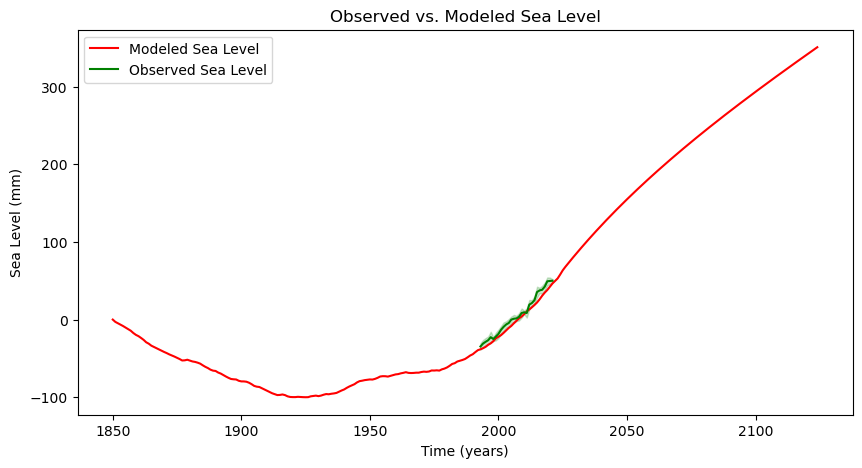

[ 14.37242196  90.15021225   8.8893547   49.20014787  60.73826372
  32.73642328 665.55512472]


In [166]:
# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)
S_model_full = np.cumsum(get_dS(T, *best_params))

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(time, S_model_full, label='Modeled Sea Level', color='red')
plt.plot(time[143:-103], S_obs, label='Observed Sea Level', color='green')

# Add uncertainty bounds
plt.fill_between(time[143:-103], S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)

plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()


popt = best_params

print(popt)

100%|██████████| 10000/10000 [00:03<00:00, 2784.43it/s]


{'allowed': 1207, 'rejected': 8793}


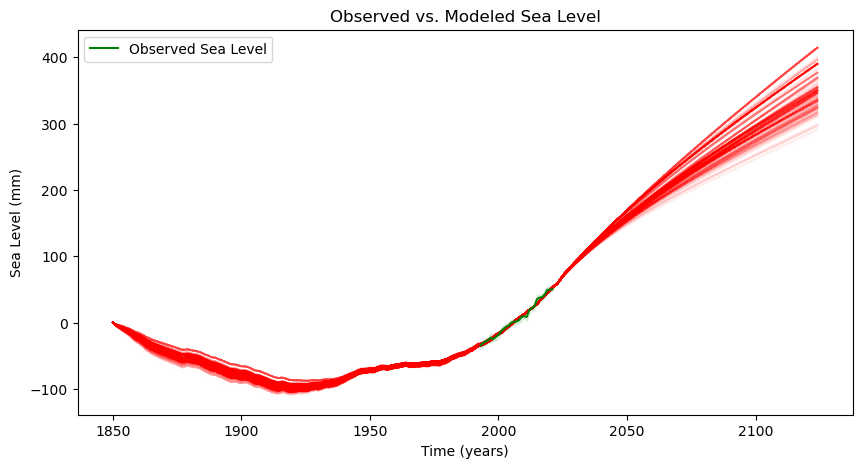

In [191]:
# show many samples
plt.figure(figsize=(10, 5))
def S_allowed(S_model_full, S_obs, sigma):
    S_cut = S_model_full[143:-103]

    return (np.abs(S_cut-S_obs) < sigma*1.7).all()

decision = {
    'allowed': 0,
    'rejected': 0
}
from tqdm import tqdm
for i in tqdm(range(10000)):
    # Use the median parameters to compute the modeled sea level
    params = samples[-i]
    S_model_full = np.cumsum(get_dS(T, *params))

    if S_allowed(S_model_full, S_obs, sigma):
        decision['allowed'] += 1
        # Plot the observed vs. modeled sea level
        plt.plot(time, S_model_full, color='red', alpha=0.01)
    else:
        decision['rejected'] += 1
    
    # plt.plot(time, S_model_full, color='red', alpha=0.01)
print(decision)
# observed sea level
plt.plot(time[143:-103], S_obs, label='Observed Sea Level', color='green')
# Add uncertainty bounds
plt.fill_between(time[143:-103], S_obs - sigma, S_obs + sigma, color='green', alpha=0.1)
    
plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()


In [169]:
S_model_full.shape

(275,)

In [190]:
sigma

array([4.15615246, 4.65891963, 4.89514979, 4.77728025, 7.0793512 ,
       2.61678232, 4.98055798, 5.48005505, 4.8059826 , 5.72361155,
       4.07450395, 5.04520158, 3.93272833, 4.9324943 , 3.41759998,
       4.71203224, 5.91008045, 2.30339503, 5.94859437, 6.02481514,
       3.69155753, 4.9015475 , 6.94410708, 3.397766  , 5.18802616,
       5.29565735, 4.95690281, 4.42832901, 2.03460327])